# Output Thresholding for class imbalance

Durante la fase de test, se divide las salidas de cada clase por el prior de dicha clase.

**En combinación con Random Oversampling (ROS)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

In [2]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=[-10,10]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = datasets.ImageFolder('../data/PlantVillage/train',data_transforms)

# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_0_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(image_dataset.targets)==1).flatten()
# class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(image_dataset, class_1_idxs)
class_0_subset = Subset(image_dataset, class_0_idxs)
image_dataset = ConcatDataset([class_0_subset, class_1_subset])
print('Total:', len(image_dataset))

Class 0: 1591 / Class 1: 373 / BDeg:  4.265415549597855
Total: 1964


In [3]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNetCustom(pl.LightningModule):
    def __init__(self,
                 gamma=0.,
                 class_sizes=[1,1],
        ):
        super().__init__()
        self.n_classes = len(class_sizes)
        c0_s, c1_s = class_sizes
        self.class_priors = torch.Tensor([(c0_s / sum(class_sizes)),
                                          (c1_s / sum(class_sizes))])
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.loss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss = self.loss(logits, y)
        mean_losses.append(mean_loss)

        return mean_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(trainloader),
                                epochs=EPOCHS)
        }

In [4]:
EPOCHS=20
K=5
GAMMA_0=2
BATCH_SIZE=10

def tensor_intersect(t1,t2):
    return torch.Tensor(np.intersect1d(t1,t2))

def make_weights_for_balanced_classes(image_indexes, class_sizes):                        
    nclasses = len(class_sizes)
    weight_per_class = [class_sizes[0]/sum(class_sizes), class_sizes[1]/sum(class_sizes)]
    weight = [0] * len(image_indexes)
    for idx, label in image_indexes.items():
        weight[int(idx)] = weight_per_class[int(label)]
    return weight

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    probabilities = torch.div(probabilities, model.class_priors) # Divide by priors (Output Thresholding)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

kfold = KFold(n_splits=K, shuffle=True)
for fold,(train_idx,val_idx) in enumerate(kfold.split(image_dataset)):
    print(f'------------fold nº {fold}----------------------')
    
    # Random Oversampling (ROS)
    ######################################################################
#     class_0, class_1 = tensor_intersect(train_idx, class_0_idxs.numpy()), tensor_intersect(train_idx, class_1_idxs.numpy())
#     c0_s, c1_s = len(class_0), len(class_1)
#     print(c0_s, c1_s, c0_s+c1_s)
#     dc0, dc1 = dict((str(int(x.item())),0) for x in class_0), dict((str(int(x.item())),1) for x in class_1)
#     image_indexes=dict(dc0,**dc1)
#     weights = make_weights_for_balanced_classes(image_indexes, [c0_s, c1_s])
#     weights = torch.DoubleTensor(weights)
#     break
#     train_subsampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(
                      image_dataset, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      image_dataset,
                      batch_size=BATCH_SIZE, sampler=val_subsampler)
    
    # Train this fold
    model = ResNetCustom(gamma=GAMMA_0, class_sizes=[c0_s, c1_s])
    trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
    trainer.fit(model, trainloader)
    
    # Test this fold
    true_y, pred_y = [], []
    for batch in tqdm(iter(testloader), total=len(testloader)):
        x, y = batch
        true_y.extend(y)
        preds, probs = get_prediction(x, model)
        pred_y.extend(preds.cpu())
    
    print(classification_report(true_y, pred_y, digits=3))

------------fold nº 0----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      1.000     0.978     0.989       323
           1      0.909     1.000     0.952        70

    accuracy                          0.982       393
   macro avg      0.955     0.989     0.971       393
weighted avg      0.984     0.982     0.983       393

------------fold nº 1----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      1.000     0.974     0.987       311
           1      0.911     1.000     0.953        82

    accuracy                          0.980       393
   macro avg      0.956     0.987     0.970       393
weighted avg      0.981     0.980     0.980       393

------------fold nº 2----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      0.997     0.984     0.991       319
           1      0.936     0.986     0.961        74

    accuracy                          0.985       393
   macro avg      0.966     0.985     0.976       393
weighted avg      0.985     0.985     0.985       393

------------fold nº 3----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      1.000     0.981     0.990       317
           1      0.927     1.000     0.962        76

    accuracy                          0.985       393
   macro avg      0.963     0.991     0.976       393
weighted avg      0.986     0.985     0.985       393

------------fold nº 4----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      1.000     0.981     0.991       321
           1      0.922     1.000     0.959        71

    accuracy                          0.985       392
   macro avg      0.961     0.991     0.975       392
weighted avg      0.986     0.985     0.985       392



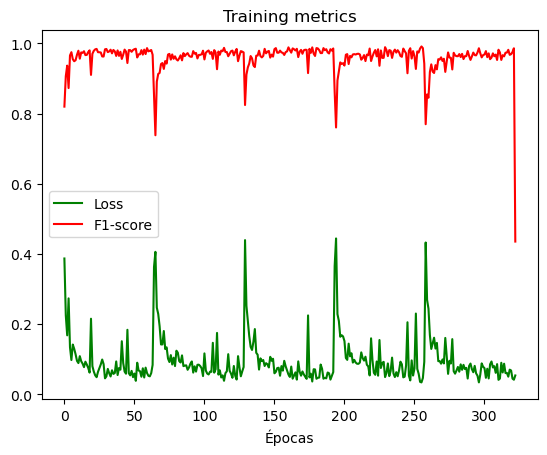

In [7]:
# Plot mean loss
x_axis = [i for i in range(323)]

splits=49
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='Accuracy')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()